In [1]:
import numpy as np
from pathlib import Path
from PIL import Image
from torch.utils.data import DataLoader, random_split
import torch
from torch import optim
import torch.nn as nn
from tqdm import tqdm
import torch.nn.functional as F
import logging
from evaluate import evaluate
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2
from collections import OrderedDict

#from model.unet.unet_model import UNet
#from model.segnet.segnet_model import SegNet
#from torchvision.models.segmentation import deeplabv3_resnet101 as DeepLabv3
from model.ensemblenet_model import EnsembleNet


from utils.dice_score import dice_loss
from utils.data_load import KittiDataset
from torchsummaryX import summary

In [2]:
Val_Percent = 0.3
Scale_Percent = 1.0
Batch_Size = 8
learning_rate = 0.0001
Pin_Memory = False
epochs = 50

#Image_Size = [384, 1242]
Image_Size = [384, 1216]
#Image_Size = [384,384]
Gradient_Clipping = 0.8

#Num_Class = 31
#Num_Class = 21
Num_Class = 2
Num_Channel = 3
amp = True

Model_Name = 'enet'


Img_Path =  'data/data_road/training/image_2'
Mask_Path =  'data/data_road/training/semantic'

save_checkpoint = False
checkpoint_dir = '../trained'
batch_size = Batch_Size

In [3]:
dirImg = Path(Img_Path)
dirMask = Path(Mask_Path)

dir_checkpoint = Path(checkpoint_dir)

train_transform = A.Compose([
        A.HorizontalFlip(p=0.5),
        #A.VerticalFlip(p=0.5),
        A.Rotate(limit=30, p=0.5),
        #A.RandomBrightnessContrast(p=0.5),
        #A.RandomGamma(p=0.5),
        #A.RandomSnow(p=0.5),
        #A.RandomRain(p=0.5),
        #A.RandomFog(p=0.5),
        #A.RandomSunFlare(p=0.5),
        A.RandomShadow(p=0.5),
        #A.RandomToneCurve(p=0.5),
        #A.GaussNoise(p=0.5),
        #A.Emboss(p=0.5),  # IAAEmboss 대신 Emboss 사용
        #A.Perspective(p=0.5),  # IAAPerspective 대신 Perspective 사용
        #A.CLAHE(p=0.5)
])

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
datasets =  KittiDataset(dirImg, dirMask, Image_Size, Scale_Percent)
#datasets =  KittiDataset(dirImg, dirMask, Image_Size, Scale_Percent, train_transform)
n_val = int(len(datasets) * Val_Percent)
n_train = len(datasets) - n_val
train_set, val_set = random_split(datasets, [n_train, n_val], generator=torch.Generator().manual_seed(0))

loader_args = dict(batch_size=Batch_Size, num_workers= os.cpu_count(), pin_memory=Pin_Memory)
train_loader = DataLoader(train_set, shuffle=True, drop_last = True, **loader_args)
val_loader = DataLoader(val_set, shuffle=False, drop_last=True, **loader_args)

100%|██████████| 289/289 [00:00<00:00, 857.41it/s]


In [6]:
model = EnsembleNet(Model_Name, Num_Channel, Num_Class)
model = model.to(memory_format=torch.channels_last, device = device)

In [7]:
# 4. Set up the optimizer, the loss, the learning rate scheduler and the loss scaling for AMP
optimizer = optim.RMSprop(model.parameters(), lr=learning_rate, weight_decay=1e-8, momentum=0.9)
#optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-8)
#optimizer = optim.SGD(model.parameters(), lr=learning_rate, weight_decay=1e-8, momentum=0.9)

if 'ensemble_voting' in Model_Name:
    unet_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=2)  # goal: maximize Dice score
    segnet_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=2)  # goal: maximize Dice score
    enet_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=2)  # goal: maximize Dice score
    voting_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=2)  # goal: maximize Dice score
    
else:
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=2)  # goal: maximize Dice score

grad_scaler = torch.cuda.amp.GradScaler(enabled=amp)
criterion = nn.CrossEntropyLoss()
global_step = 0

In [8]:
def calculate_loss(pred, true_masks, nclass, multiclass):
    loss = criterion(pred, true_masks)
    loss += dice_loss(
        F.softmax(pred, dim=1).float(),
        F.one_hot(true_masks, nclass).permute(0, 3, 1, 2).float(),
        multiclass=multiclass
    )
    return loss


def forward_and_backward(model, images, true_masks, amp, optimizer, grad_scaler, model_name):
    with torch.autocast(device.type if device.type != 'mps' else 'cpu', enabled=amp):
        if model_name == 'ensemble_voting':
            unet_pred, segnet_pred, enet_pred = model(images)
            #deeplab_pred = deeplab_pred['out']
        else:
            masks_pred = model(images)
            if isinstance(masks_pred, OrderedDict):
                masks_pred = masks_pred['out']

        try:
            mn_cls = model.n_classes
        except:
            mn_cls = model.classifier[-1].out_channels


        if model_name == 'ensemble_voting':
            unet_loss = calculate_loss(unet_pred, true_masks, mn_cls, multiclass=True)
            segnet_loss = calculate_loss(segnet_pred, true_masks, mn_cls, multiclass=True)
            enet_loss = calculate_loss(enet_pred, true_masks, mn_cls, multiclass=True)
            
        else:
            loss = calculate_loss(masks_pred, true_masks, mn_cls, multiclass=True)

    
    optimizer.zero_grad(set_to_none=True)
    if model_name == 'ensemble_voting':
        for pred, loss in zip([unet_pred, segnet_pred, enet_pred], [unet_loss, segnet_loss, enet_loss]):
            grad_scaler.scale(loss).backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), Gradient_Clipping)
            grad_scaler.step(optimizer)
            grad_scaler.update()
        
        return model, unet_loss, segnet_loss, enet_loss
    else:
        optimizer.zero_grad(set_to_none=True)
        grad_scaler.scale(loss).backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), Gradient_Clipping)
        grad_scaler.step(optimizer)
        grad_scaler.update()
        
        return model, loss


In [9]:
valScore_list1 = []
TrainLoss_list1 = []

valScore_list2 = []
TrainLoss_list2 = []

valScore_list3 = []
TrainLoss_list3 = []

valScore_list4 = []
TrainLoss_list4 = []

val_losses = []
val_accs = []
val_mious = []

# 5. Begin training
for epoch in range(1, epochs + 1):
    model.train()
    epoch_loss = 0
    epoch_unet_loss = 0
    epoch_segnet_loss = 0
    epoch_enet_loss = 0
    epoch_voting_loss = 0
    
    with tqdm(total=n_train, desc=f'Epoch {epoch}/{epochs}', unit='img') as pbar:
        for batch in train_loader:
            images, true_masks = batch['image'], batch['mask']

            images = images.to(device=device, dtype=torch.float32, memory_format=torch.channels_last)
            true_masks = true_masks.to(device=device, dtype=torch.long)

                
            result = forward_and_backward(model, images, true_masks, amp, optimizer, grad_scaler, Model_Name)
            
            if len(result) == 4:
                model, unet_loss, segnet_loss, enet_loss = result
                
                pbar.update(images.shape[0])
                global_step += 1
                epoch_unet_loss += unet_loss.item()
                epoch_segnet_loss += segnet_loss.item()
                epoch_enet_loss += enet_loss.item()
                vot_loss = ((unet_loss.item() + segnet_loss.item() + enet_loss.item()) /3)
                epoch_voting_loss += vot_loss
                
                
            elif len(result) == 2:
                model, loss = result
                
                pbar.update(images.shape[0])
                global_step += 1
                epoch_loss += loss.item()


        print('***')
        if len(result) == 4:
            print('Unet Loss: {}     Segnet Loss: {}     Enet Loss: {}'.format(unet_loss, segnet_loss, enet_loss))
            print('Voting Loss: {}'.format(vot_loss))
            
            
        elif len(result) == 2:
            print('{} Loss: {}'.format(Model_Name, loss))

        # Evaluation round
        division_step = (n_train // (5 * batch_size))
        if division_step > 0:
            #if global_step % division_step == 0:
            if len(result) == 4:
                unet_val_score, segnet_val_score, enet_val_score, voting_val_score, val_loss, val_acc, val_miou = evaluate(model, val_loader, criterion, device, Model_Name, amp)
                
                unet_scheduler.step(unet_val_score)
                segnet_scheduler.step(segnet_val_score)
                enet_scheduler.step(enet_val_score)
                voting_scheduler.step(voting_val_score)
                
                valScore_list1.append(unet_val_score)
                TrainLoss_list1.append(unet_loss)
                valScore_list2.append(segnet_val_score)
                TrainLoss_list2.append(segnet_loss)                
                valScore_list3.append(enet_val_score)
                TrainLoss_list3.append(enet_loss)
                valScore_list4.append(voting_val_score)
                TrainLoss_list4.append(vot_loss)
                
                val_losses.append(val_loss)
                val_accs.append(val_acc)
                val_mious.append(val_miou)
                
                print('---')
                print('Unet Validation Dice Score: {}     Segnet Validation Dice Score: {}     Enet Validation Dice Score: {}'.format(unet_val_score, segnet_val_score, enet_val_score))
                
                print('Ensemble Voting Validation Dice Loss: {}'.format(val_loss))
                print('Ensemble Voting Validation Pixel Accuracy: {} '.format(val_acc))
                print('Ensemble Voting Validation MIoU: {}'.format(val_miou))                
                print('Ensemble Voting Validation Dice Score: {} '.format(voting_val_score))
                
            else:
                val_score, val_loss, val_acc, val_miou = evaluate(model, val_loader, criterion, device, Model_Name, amp)
                
                
                
                scheduler.step(val_score)
                
                print('---')
                print('{} Validation Dice Loss: {}'.format(Model_Name, val_loss))   
                print('{} Validation Pixel Accuracy: {}'.format(Model_Name, val_acc))
                print('{} Validation MIoU: {}'.format(Model_Name, val_miou))
                print('{} Validation Dice Score: {}'.format(Model_Name, val_score))
                
            
                valScore_list1.append(val_score.cpu().detach().numpy())
                TrainLoss_list1.append(loss.cpu().detach().numpy())
                val_losses.append(val_loss)
                val_accs.append(val_acc)
                val_mious.append(val_miou)

                #valScore_list.append(val_score)
                #TrainLoss_list.append(loss)
                #print('Validation Dice score: {}'.format(val_score))
                                
        
    if save_checkpoint:
        Path(dir_checkpoint).mkdir(parents=True, exist_ok=True)
        torch.save(model.state_dict(), str(dir_checkpoint / 'checkpoint_epoch{}.pth'.format(epoch + 1)))

Epoch 1/50:  99%|█████████▊| 200/203 [00:09<00:00, 38.24img/s]

***
enet Loss: 0.47645145654678345


Epoch 1/50:  99%|█████████▊| 200/203 [00:11<00:00, 17.04img/s]


---
enet Validation Dice Loss: 0.9534223079681396
enet Validation Pixel Accuracy: 0.8505754972759046
enet Validation MIoU: 0.42529738183889554
enet Validation Dice Score: 3.2301144528901204e-05


Epoch 2/50:  99%|█████████▊| 200/203 [00:07<00:00, 37.80img/s]

***
enet Loss: 0.4208170175552368


Epoch 2/50:  99%|█████████▊| 200/203 [00:09<00:00, 20.67img/s]


---
enet Validation Dice Loss: 0.3838843107223511
enet Validation Pixel Accuracy: 0.8504986679344847
enet Validation MIoU: 0.4252624629948122
enet Validation Dice Score: 4.275701576261781e-05


Epoch 3/50:  99%|█████████▊| 200/203 [00:07<00:00, 38.04img/s]

***
enet Loss: 0.3394240140914917


Epoch 3/50:  99%|█████████▊| 200/203 [00:09<00:00, 20.53img/s]


---
enet Validation Dice Loss: 0.41104066371917725
enet Validation Pixel Accuracy: 0.8535900450589364
enet Validation MIoU: 0.585435407199627
enet Validation Dice Score: 0.5345163941383362


Epoch 4/50:  99%|█████████▊| 200/203 [00:07<00:00, 36.56img/s]

***
enet Loss: 0.24720191955566406


Epoch 4/50:  99%|█████████▊| 200/203 [00:09<00:00, 20.28img/s]


---
enet Validation Dice Loss: 0.32733067870140076
enet Validation Pixel Accuracy: 0.9043557685718202
enet Validation MIoU: 0.6843135500157871
enet Validation Dice Score: 0.7109952569007874


Epoch 5/50:  99%|█████████▊| 200/203 [00:07<00:00, 37.36img/s]

***
enet Loss: 0.2653025984764099


Epoch 5/50:  99%|█████████▊| 200/203 [00:09<00:00, 20.52img/s]


---
enet Validation Dice Loss: 0.26306983828544617
enet Validation Pixel Accuracy: 0.941522430955318
enet Validation MIoU: 0.8170408750193675
enet Validation Dice Score: 0.8584116101264954


Epoch 6/50:  99%|█████████▊| 200/203 [00:07<00:00, 38.22img/s]

***
enet Loss: 0.31556040048599243


Epoch 6/50:  99%|█████████▊| 200/203 [00:09<00:00, 20.20img/s]


---
enet Validation Dice Loss: 0.32054075598716736
enet Validation Pixel Accuracy: 0.9221054880242598
enet Validation MIoU: 0.7450408829293964
enet Validation Dice Score: 0.782128632068634


Epoch 7/50:  99%|█████████▊| 200/203 [00:07<00:00, 37.98img/s]

***
enet Loss: 0.21278613805770874


Epoch 7/50:  99%|█████████▊| 200/203 [00:09<00:00, 20.74img/s]


---
enet Validation Dice Loss: 0.35947781801223755
enet Validation Pixel Accuracy: 0.9140552721525493
enet Validation MIoU: 0.7277008162965719
enet Validation Dice Score: 0.7902736663818359


Epoch 8/50:  99%|█████████▊| 200/203 [00:07<00:00, 38.02img/s]

***
enet Loss: 0.21298809349536896


Epoch 8/50:  99%|█████████▊| 200/203 [00:09<00:00, 20.80img/s]


---
enet Validation Dice Loss: 0.1677064597606659
enet Validation Pixel Accuracy: 0.9634819700006854
enet Validation MIoU: 0.8728889770520415
enet Validation Dice Score: 0.8727861642837524


Epoch 9/50:  99%|█████████▊| 200/203 [00:07<00:00, 37.52img/s]

***
enet Loss: 0.0972893014550209


Epoch 9/50:  99%|█████████▊| 200/203 [00:09<00:00, 20.30img/s]


---
enet Validation Dice Loss: 0.1674260050058365
enet Validation Pixel Accuracy: 0.9567828262061403
enet Validation MIoU: 0.857713352655852
enet Validation Dice Score: 0.8847494125366211


Epoch 10/50:  99%|█████████▊| 200/203 [00:07<00:00, 37.76img/s]

***
enet Loss: 0.12270216643810272


Epoch 10/50:  99%|█████████▊| 200/203 [00:09<00:00, 20.46img/s]


---
enet Validation Dice Loss: 0.18981140851974487
enet Validation Pixel Accuracy: 0.951199447899534
enet Validation MIoU: 0.8453203570575871
enet Validation Dice Score: 0.8739509582519531


Epoch 11/50:  99%|█████████▊| 200/203 [00:06<00:00, 37.81img/s]

***
enet Loss: 0.12054076790809631


Epoch 11/50:  99%|█████████▊| 200/203 [00:09<00:00, 21.19img/s]


---
enet Validation Dice Loss: 0.1341303586959839
enet Validation Pixel Accuracy: 0.9662336382949561
enet Validation MIoU: 0.883954094893814
enet Validation Dice Score: 0.9032421112060547


Epoch 12/50:  99%|█████████▊| 200/203 [00:07<00:00, 37.74img/s]

***
enet Loss: 0.11607537418603897


Epoch 12/50:  99%|█████████▊| 200/203 [00:09<00:00, 20.59img/s]


---
enet Validation Dice Loss: 0.12062361091375351
enet Validation Pixel Accuracy: 0.970794677734375
enet Validation MIoU: 0.8975345819985578
enet Validation Dice Score: 0.9024084210395813


Epoch 13/50:  99%|█████████▊| 200/203 [00:07<00:00, 38.85img/s]

***
enet Loss: 0.10406682640314102


Epoch 13/50:  99%|█████████▊| 200/203 [00:09<00:00, 20.17img/s]


---
enet Validation Dice Loss: 0.11599507182836533
enet Validation Pixel Accuracy: 0.970586944044682
enet Validation MIoU: 0.8954837728932892
enet Validation Dice Score: 0.9154638648033142


Epoch 14/50:  99%|█████████▊| 200/203 [00:07<00:00, 38.06img/s]

***
enet Loss: 0.13717426359653473


Epoch 14/50:  99%|█████████▊| 200/203 [00:09<00:00, 20.58img/s]


---
enet Validation Dice Loss: 0.11900080740451813
enet Validation Pixel Accuracy: 0.9688883998937774
enet Validation MIoU: 0.8881767836374932
enet Validation Dice Score: 0.9086174368858337


Epoch 15/50:  99%|█████████▊| 200/203 [00:07<00:00, 37.55img/s]

***
enet Loss: 0.07112573087215424


Epoch 15/50:  99%|█████████▊| 200/203 [00:09<00:00, 20.12img/s]


---
enet Validation Dice Loss: 0.11583688110113144
enet Validation Pixel Accuracy: 0.9674372087445176
enet Validation MIoU: 0.8859080557836532
enet Validation Dice Score: 0.9108735918998718


Epoch 16/50:  99%|█████████▊| 200/203 [00:07<00:00, 37.73img/s]

***
enet Loss: 0.11849693208932877


Epoch 16/50:  99%|█████████▊| 200/203 [00:09<00:00, 20.16img/s]


---
enet Validation Dice Loss: 0.08942368626594543
enet Validation Pixel Accuracy: 0.9787809137712445
enet Validation MIoU: 0.9194885754773972
enet Validation Dice Score: 0.9239752888679504


Epoch 17/50:  99%|█████████▊| 200/203 [00:07<00:00, 37.48img/s]

***
enet Loss: 0.05208510905504227


Epoch 17/50:  99%|█████████▊| 200/203 [00:09<00:00, 20.25img/s]


---
enet Validation Dice Loss: 0.1180855855345726
enet Validation Pixel Accuracy: 0.9715394137198465
enet Validation MIoU: 0.899550514918828
enet Validation Dice Score: 0.9171448945999146


Epoch 18/50:  99%|█████████▊| 200/203 [00:07<00:00, 37.71img/s]

***
enet Loss: 0.09923114627599716


Epoch 18/50:  99%|█████████▊| 200/203 [00:09<00:00, 20.47img/s]


---
enet Validation Dice Loss: 0.11296969652175903
enet Validation Pixel Accuracy: 0.9701942309998629
enet Validation MIoU: 0.8969223340020466
enet Validation Dice Score: 0.9150020480155945


Epoch 19/50:  99%|█████████▊| 200/203 [00:06<00:00, 40.33img/s]

***
enet Loss: 0.056847382336854935


Epoch 19/50:  99%|█████████▊| 200/203 [00:09<00:00, 20.73img/s]


---
enet Validation Dice Loss: 0.09250543266534805
enet Validation Pixel Accuracy: 0.9780948036595395
enet Validation MIoU: 0.9160284765543226
enet Validation Dice Score: 0.8987696766853333


Epoch 20/50:  99%|█████████▊| 200/203 [00:07<00:00, 37.53img/s]

***
enet Loss: 0.07322010397911072


Epoch 20/50:  99%|█████████▊| 200/203 [00:09<00:00, 20.48img/s]


---
enet Validation Dice Loss: 0.08001304417848587
enet Validation Pixel Accuracy: 0.9786580403645834
enet Validation MIoU: 0.9223906884105595
enet Validation Dice Score: 0.9395655989646912


Epoch 21/50:  99%|█████████▊| 200/203 [00:07<00:00, 37.46img/s]

***
enet Loss: 0.05319688469171524


Epoch 21/50:  99%|█████████▊| 200/203 [00:09<00:00, 20.46img/s]


---
enet Validation Dice Loss: 0.06962497532367706
enet Validation Pixel Accuracy: 0.9817454020182291
enet Validation MIoU: 0.932280539229354
enet Validation Dice Score: 0.9451091885566711


Epoch 22/50:  99%|█████████▊| 200/203 [00:07<00:00, 37.83img/s]

***
enet Loss: 0.04475954920053482


Epoch 22/50:  99%|█████████▊| 200/203 [00:09<00:00, 20.41img/s]


---
enet Validation Dice Loss: 0.06566063314676285
enet Validation Pixel Accuracy: 0.9824796977796053
enet Validation MIoU: 0.9351718705051427
enet Validation Dice Score: 0.9471166729927063


Epoch 23/50:  99%|█████████▊| 200/203 [00:07<00:00, 38.65img/s]

***
enet Loss: 0.042406126856803894


Epoch 23/50:  99%|█████████▊| 200/203 [00:09<00:00, 20.25img/s]


---
enet Validation Dice Loss: 0.06424243748188019
enet Validation Pixel Accuracy: 0.9833224112527412
enet Validation MIoU: 0.9375938763200027
enet Validation Dice Score: 0.9452120661735535


Epoch 24/50:  99%|█████████▊| 200/203 [00:07<00:00, 37.71img/s]

***
enet Loss: 0.034098781645298004


Epoch 24/50:  99%|█████████▊| 200/203 [00:09<00:00, 20.17img/s]


---
enet Validation Dice Loss: 0.06306682527065277
enet Validation Pixel Accuracy: 0.9834150347793311
enet Validation MIoU: 0.9377390983351671
enet Validation Dice Score: 0.9453456997871399


Epoch 25/50:  99%|█████████▊| 200/203 [00:07<00:00, 37.62img/s]

***
enet Loss: 0.0406452901661396


Epoch 25/50:  99%|█████████▊| 200/203 [00:09<00:00, 20.62img/s]


---
enet Validation Dice Loss: 0.06701172888278961
enet Validation Pixel Accuracy: 0.9820358544065241
enet Validation MIoU: 0.9331974948858439
enet Validation Dice Score: 0.9446315765380859


Epoch 26/50:  99%|█████████▊| 200/203 [00:07<00:00, 37.78img/s]

***
enet Loss: 0.04594036191701889


Epoch 26/50:  99%|█████████▊| 200/203 [00:09<00:00, 20.77img/s]


---
enet Validation Dice Loss: 0.06625957041978836
enet Validation Pixel Accuracy: 0.9822893644634046
enet Validation MIoU: 0.9341592184478353
enet Validation Dice Score: 0.945679783821106


Epoch 27/50:  99%|█████████▊| 200/203 [00:07<00:00, 36.53img/s]

***
enet Loss: 0.060677383095026016


Epoch 27/50:  99%|█████████▊| 200/203 [00:09<00:00, 20.56img/s]


---
enet Validation Dice Loss: 0.06312301754951477
enet Validation Pixel Accuracy: 0.9833545350191886
enet Validation MIoU: 0.9377054666259188
enet Validation Dice Score: 0.9462756514549255


Epoch 28/50:  99%|█████████▊| 200/203 [00:07<00:00, 36.58img/s]

***
enet Loss: 0.04353354126214981


Epoch 28/50:  99%|█████████▊| 200/203 [00:09<00:00, 20.56img/s]


---
enet Validation Dice Loss: 0.06727153807878494
enet Validation Pixel Accuracy: 0.9819078947368421
enet Validation MIoU: 0.9329735389880953
enet Validation Dice Score: 0.9467992782592773


Epoch 29/50:  99%|█████████▊| 200/203 [00:07<00:00, 37.04img/s]

***
enet Loss: 0.04882431775331497


Epoch 29/50:  99%|█████████▊| 200/203 [00:09<00:00, 20.67img/s]


---
enet Validation Dice Loss: 0.06488674879074097
enet Validation Pixel Accuracy: 0.9828750878049616
enet Validation MIoU: 0.9359292033211708
enet Validation Dice Score: 0.9464551210403442


Epoch 30/50:  99%|█████████▊| 200/203 [00:07<00:00, 37.76img/s]

***
enet Loss: 0.04826667904853821


Epoch 30/50:  99%|█████████▊| 200/203 [00:09<00:00, 20.34img/s]


---
enet Validation Dice Loss: 0.06562305986881256
enet Validation Pixel Accuracy: 0.982468186763295
enet Validation MIoU: 0.9347932711422138
enet Validation Dice Score: 0.9462011456489563


Epoch 31/50:  99%|█████████▊| 200/203 [00:07<00:00, 37.80img/s]

***
enet Loss: 0.06960554420948029


Epoch 31/50:  99%|█████████▊| 200/203 [00:09<00:00, 20.59img/s]


---
enet Validation Dice Loss: 0.0664609968662262
enet Validation Pixel Accuracy: 0.9822152121025219
enet Validation MIoU: 0.9339370669411833
enet Validation Dice Score: 0.945999264717102


Epoch 32/50:  99%|█████████▊| 200/203 [00:07<00:00, 37.69img/s]

***
enet Loss: 0.041228070855140686


Epoch 32/50:  99%|█████████▊| 200/203 [00:09<00:00, 20.33img/s]


---
enet Validation Dice Loss: 0.06545946002006531
enet Validation Pixel Accuracy: 0.9825835646244517
enet Validation MIoU: 0.9350650159381527
enet Validation Dice Score: 0.947237491607666


Epoch 33/50:  99%|█████████▊| 200/203 [00:07<00:00, 37.63img/s]

***
enet Loss: 0.04575473070144653


Epoch 33/50:  99%|█████████▊| 200/203 [00:09<00:00, 20.80img/s]


---
enet Validation Dice Loss: 0.06551526486873627
enet Validation Pixel Accuracy: 0.9826189007675439
enet Validation MIoU: 0.9350895681704253
enet Validation Dice Score: 0.9471640586853027


Epoch 34/50:  99%|█████████▊| 200/203 [00:07<00:00, 36.32img/s]

***
enet Loss: 0.0409160815179348


Epoch 34/50:  99%|█████████▊| 200/203 [00:09<00:00, 20.48img/s]


---
enet Validation Dice Loss: 0.06594720482826233
enet Validation Pixel Accuracy: 0.9822915060478344
enet Validation MIoU: 0.9341541062976804
enet Validation Dice Score: 0.9473808407783508


Epoch 35/50:  99%|█████████▊| 200/203 [00:07<00:00, 37.96img/s]

***
enet Loss: 0.04220009595155716


Epoch 35/50:  99%|█████████▊| 200/203 [00:09<00:00, 20.26img/s]


---
enet Validation Dice Loss: 0.06427435576915741
enet Validation Pixel Accuracy: 0.9828916850842928
enet Validation MIoU: 0.9361659774579865
enet Validation Dice Score: 0.9463920593261719


Epoch 36/50:  99%|█████████▊| 200/203 [00:07<00:00, 37.52img/s]

***
enet Loss: 0.06112450361251831


Epoch 36/50:  99%|█████████▊| 200/203 [00:09<00:00, 20.19img/s]


---
enet Validation Dice Loss: 0.0652485340833664
enet Validation Pixel Accuracy: 0.982599091111568
enet Validation MIoU: 0.9351171998691177
enet Validation Dice Score: 0.9462942481040955


Epoch 37/50:  99%|█████████▊| 200/203 [00:07<00:00, 36.93img/s]

***
enet Loss: 0.06012573838233948


Epoch 37/50:  99%|█████████▊| 200/203 [00:09<00:00, 20.59img/s]


---
enet Validation Dice Loss: 0.0639534443616867
enet Validation Pixel Accuracy: 0.9831874914336622
enet Validation MIoU: 0.9369800737161598
enet Validation Dice Score: 0.9458622932434082


Epoch 38/50:  99%|█████████▊| 200/203 [00:07<00:00, 39.85img/s]

***
enet Loss: 0.04765733331441879


Epoch 38/50:  99%|█████████▊| 200/203 [00:09<00:00, 21.03img/s]


---
enet Validation Dice Loss: 0.06748312711715698
enet Validation Pixel Accuracy: 0.982019257127193
enet Validation MIoU: 0.9332219596036291
enet Validation Dice Score: 0.9475013613700867


Epoch 39/50:  99%|█████████▊| 200/203 [00:07<00:00, 37.79img/s]

***
enet Loss: 0.08311901986598969


Epoch 39/50:  99%|█████████▊| 200/203 [00:09<00:00, 20.58img/s]


---
enet Validation Dice Loss: 0.06516215950250626
enet Validation Pixel Accuracy: 0.982699477881716
enet Validation MIoU: 0.9354774909683281
enet Validation Dice Score: 0.9476715326309204


Epoch 40/50:  99%|█████████▊| 200/203 [00:06<00:00, 37.61img/s]

***
enet Loss: 0.050298549234867096


Epoch 40/50:  99%|█████████▊| 200/203 [00:09<00:00, 21.11img/s]


---
enet Validation Dice Loss: 0.06538183987140656
enet Validation Pixel Accuracy: 0.9825613456859923
enet Validation MIoU: 0.9350592446196279
enet Validation Dice Score: 0.9464604258537292


Epoch 41/50:  99%|█████████▊| 200/203 [00:07<00:00, 39.09img/s]

***
enet Loss: 0.053554028272628784


Epoch 41/50:  99%|█████████▊| 200/203 [00:09<00:00, 20.47img/s]


---
enet Validation Dice Loss: 0.06629088521003723
enet Validation Pixel Accuracy: 0.9823206851356908
enet Validation MIoU: 0.9342780638739383
enet Validation Dice Score: 0.9462879300117493


Epoch 42/50:  99%|█████████▊| 200/203 [00:07<00:00, 38.33img/s]

***
enet Loss: 0.047337405383586884


Epoch 42/50:  99%|█████████▊| 200/203 [00:09<00:00, 20.65img/s]


---
enet Validation Dice Loss: 0.06799159944057465
enet Validation Pixel Accuracy: 0.9818556936163652
enet Validation MIoU: 0.9327174780547081
enet Validation Dice Score: 0.9468590021133423


Epoch 43/50:  99%|█████████▊| 200/203 [00:07<00:00, 37.52img/s]

***
enet Loss: 0.03923522308468819


Epoch 43/50:  99%|█████████▊| 200/203 [00:09<00:00, 20.53img/s]


---
enet Validation Dice Loss: 0.06608683615922928
enet Validation Pixel Accuracy: 0.9822674132229989
enet Validation MIoU: 0.9340258452682093
enet Validation Dice Score: 0.9460448622703552


Epoch 44/50:  99%|█████████▊| 200/203 [00:07<00:00, 36.42img/s]

***
enet Loss: 0.0539013035595417


Epoch 44/50:  99%|█████████▊| 200/203 [00:09<00:00, 20.31img/s]


---
enet Validation Dice Loss: 0.06828227639198303
enet Validation Pixel Accuracy: 0.9817424573396382
enet Validation MIoU: 0.932343831421172
enet Validation Dice Score: 0.9473770260810852


Epoch 45/50:  99%|█████████▊| 200/203 [00:07<00:00, 37.43img/s]

***
enet Loss: 0.04612702131271362


Epoch 45/50:  99%|█████████▊| 200/203 [00:09<00:00, 20.42img/s]


---
enet Validation Dice Loss: 0.0686330795288086
enet Validation Pixel Accuracy: 0.9816658956962719
enet Validation MIoU: 0.9321224519369431
enet Validation Dice Score: 0.9468552470207214


Epoch 46/50:  99%|█████████▊| 200/203 [00:07<00:00, 37.54img/s]

***
enet Loss: 0.06526082754135132


Epoch 46/50:  99%|█████████▊| 200/203 [00:09<00:00, 20.18img/s]


---
enet Validation Dice Loss: 0.06872516870498657
enet Validation Pixel Accuracy: 0.9816808867872807
enet Validation MIoU: 0.9321288995218963
enet Validation Dice Score: 0.9468016624450684


Epoch 47/50:  99%|█████████▊| 200/203 [00:07<00:00, 37.65img/s]

***
enet Loss: 0.05261162668466568


Epoch 47/50:  99%|█████████▊| 200/203 [00:09<00:00, 20.73img/s]


---
enet Validation Dice Loss: 0.06424281746149063
enet Validation Pixel Accuracy: 0.9828357361910636
enet Validation MIoU: 0.9360496524069604
enet Validation Dice Score: 0.9465212821960449


Epoch 48/50:  99%|█████████▊| 200/203 [00:07<00:00, 37.64img/s]

***
enet Loss: 0.03969071805477142


Epoch 48/50:  99%|█████████▊| 200/203 [00:09<00:00, 20.27img/s]


---
enet Validation Dice Loss: 0.06461361050605774
enet Validation Pixel Accuracy: 0.9828164619311952
enet Validation MIoU: 0.9358964882922199
enet Validation Dice Score: 0.9460694193840027


Epoch 49/50:  99%|█████████▊| 200/203 [00:07<00:00, 37.54img/s]

***
enet Loss: 0.044501207768917084


Epoch 49/50:  99%|█████████▊| 200/203 [00:09<00:00, 20.56img/s]


---
enet Validation Dice Loss: 0.06750469654798508
enet Validation Pixel Accuracy: 0.9820294296532347
enet Validation MIoU: 0.9330914982127749
enet Validation Dice Score: 0.945675790309906


Epoch 50/50:  99%|█████████▊| 200/203 [00:07<00:00, 37.40img/s]

***
enet Loss: 0.042800597846508026


Epoch 50/50:  99%|█████████▊| 200/203 [00:09<00:00, 20.44img/s]

---
enet Validation Dice Loss: 0.06531785428524017
enet Validation Pixel Accuracy: 0.9825471576891447
enet Validation MIoU: 0.9349497059069184
enet Validation Dice Score: 0.9462193846702576


In [19]:
import pandas as pd
import matplotlib.pyplot as plt

In [20]:
df = pd.DataFrame([TrainLoss_list1, val_losses, valScore_list1, val_accs, val_mious]).T
df.columns = ['train_loss', 'val_loss', 'val_score', 'val_acc', 'val_miou']

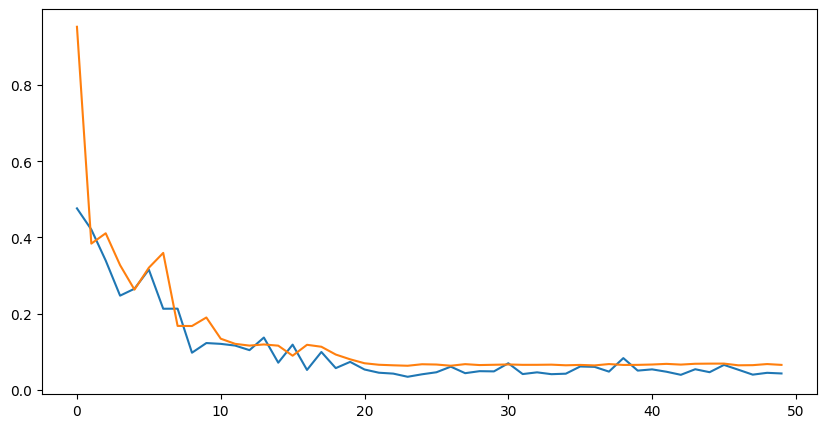

In [21]:
plt.figure(figsize= (10,5))
plt.plot(TrainLoss_list1)
plt.plot(val_losses)
#plt.show()

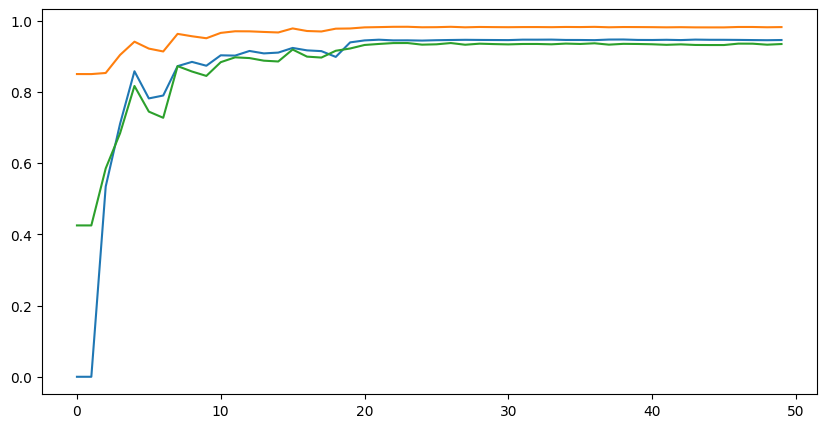

In [22]:
plt.figure(figsize= (10,5))
plt.plot(valScore_list1)
plt.plot(val_accs)
plt.plot(val_mious)
#plt.show()